# Getting started

In this tutorial, we will do parameter inference on a simple statistical model. 

First off, let's see whether `delfi` is installed properly:

In [1]:
import delfi
print(delfi.__version__)

0.5.1


No error was raised, and we can continue.

## Simulator

For the purpose of this example, we will consider a very simple statistical model, with a single parameter $\theta$. Depending on $\theta$, data is generated according to: $x|\mathbf{\theta} \sim 0.5 \mathcal{N}(x|\mu=\theta, \sigma^2=1) + 0.5 \mathcal{N}(x|\mu=\theta, \sigma^2=0.1)$

This model is implemented in `delfi.simulator`, we will import the model and create an instance:

In [2]:
from delfi.simulator import GaussMixture

n_params = 1
m = GaussMixture(dim=n_params)

## Prior

Next, we will define a prior distribution over $\theta$ as $\mathcal{U}(-10, 10)$:

In [3]:
import delfi.distribution as dd
import numpy as np

p = dd.Uniform(lower=[-10], upper=[10])

## Summary statistics

We will not reduce the dimensionality of our data, and instead just apply the identity:

In [4]:
from delfi.summarystats import Identity

s = Identity()

## Generator

Having defined the simulator, prior, and summary statistics, we instantiate a generator object:

In [5]:
from delfi.generator import Default

g = Default(model=m, prior=p, summary=s)

Having specified the generator, we can draw parameters and data using the `gen()` method:

In [6]:
params, stats = g.gen(500)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

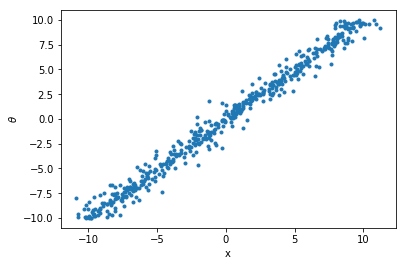

In [8]:
plt.plot(stats, params, '.')
plt.ylabel(r'$\theta$')
plt.xlabel(r'x');

## Inference

Say, we observed data $x_\text{o}$ and are interested in the posterior distribution $p(\theta|x=x_\text{o})$. The likelihood-free inference (LFI) algorithms implemented in `delfi` allow doing so, without using the likelihood function: In most real world application, the likelihood function is not available. We aim to do inference by just generating examples, i.e., simulating the model. 

We choose the toy model such that the posterior is easily tractable analytically. This will allow us to judge the result against the ground truth. We will carry out inference for $x_0 = 0$.

In [9]:
x0 = np.array([[0.]])

## Basic density estimation based LFI

A simple algorithm to use density estimation for LFI looks as follows:

![](../algorithms/basic.svg)

$q_\phi$ will be a mixture density network (MDN): The MDN is a neural network that maps from $x$ to a Gaussian mixture distribution. 

For our example, we will set $K=2$, such that the resulting mixtures will have two components.

To apply the above algorithm to the toy problem, create an instance of the inference algorithm specifying details:

In [10]:
from delfi.inference import Basic

inf_basic = Basic(obs = x0, generator=g, n_components=2, n_hiddens=[10])

/opt/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


We specified that we want K=2 components, and the neural network got a single hidden layer with 10 units. Additional entries in the list passed for `n_hiddens` would create additional layers.

In [11]:
log, train_data, _ = inf_basic.run(n_train=5000)

We drew N=n_train training examples and ran the algorithm. We can plot the loss function, across training rounds of the neural network:

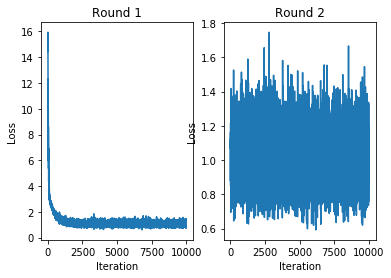

In [12]:
plt.figure()
for i in range(len(log)):
    plt.subplot(1, len(log), i + 1)
    plt.plot(log[i]['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Round {0}'.format(i + 1))

Say we observed $x_o = 0.$ and want to predict the posterior $\hat{p}(\theta | x=x_{\text{o}})$:

In [13]:
posterior = inf_basic.predict(x0)

The parameters of the predicted posterior are:

In [14]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))

component 1: mixture weight = 0.57; mean = 0.03; variance = 0.10
component 2: mixture weight = 0.43; mean = -0.00; variance = 1.28


The correct posterior for this problem is known -- since the prior is uniform it is simply: 

$$p(\theta|x=x_{\text{o}}) = 0.5 \mathcal{N}(\theta|\mu=0, \sigma^2=1) + 0.5 \mathcal{N}(\theta|\mu=0, \sigma^2=0.1)$$

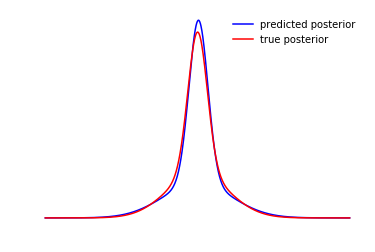

In [15]:
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

# Sequential Neural Posterior Estimation

For the problem we picked here, the basic inference algorithm does a good job. More complicated problems, however, may require more sophisticated algorithms. 

Instead of sampling all parameters from the prior, we can use our simulator more efficiently by drawin only a first sent of parameters from the prior and then switch to using a different distribution to sample from (a proposal distribution). Intuitively, the proposal distribution is chosen such that, when simulated, data is closer to $x_o$. In order to get the correct posterior, we will need to account for the fact that we drew these samples from a different distribution. There are three inference methods impelemented in delfi, each with a different approaches to this problem.

## SNPE-A

SNPE-A, also known as Conditional Density Estimation Likelihood-Free Inference (CDELFI), implements an algorithm by Papamakarios and Murray (2016). Here the posterior is inferred as if the proposal had been the prior, and then a correction is calculated to the resulting probability distribution. For details see:
[Fast ε-free Inference of Simulation Models with Bayesian Conditional Density Estimation](https://arxiv.org/abs/1605.06376v3).

The use of SNPE-A is demonstrated below

In [16]:
from delfi.inference import SNPEA
g.proposal = None  # may have been set to something else, e.g. Student's T mixture, above
inf_A = SNPEA(generator=g, n_components=2, n_hiddens=[10], obs=x0)
logs, tds, posteriors = inf_A.run(n_train=[2000, 1000], n_rounds=2)
posterior = posteriors[-1]

component 1: mixture weight = 0.33; mean = 0.04; variance = 0.07
component 2: mixture weight = 0.67; mean = 0.03; variance = 1.06


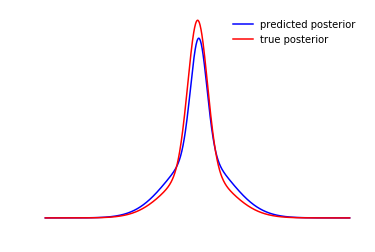

In [17]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))
    
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## SNPE-B
Another way to infer the true posteror while sampling from a proposal is by using an importance-weighted loss. This removes the need for a post-hoc correction and leads to the SNPE-B algorithm, as described in [Flexible statistical inference for mechanistic models of neural dynamics](https://arxiv.org/abs/1605.06376v3) by Lueckemann et al.

![](../algorithms/snpeB.svg)

In [18]:
from delfi.inference import SNPEB

inf_B = SNPEB(generator=g, n_components=2, n_hiddens=[10], obs=x0)
logs, tds, posteriors = inf_B.run(n_train=[2000, 1000], n_rounds=2)
posterior = posteriors[-1]

component 1: mixture weight = 0.31; mean = -0.03; variance = 0.02
component 2: mixture weight = 0.69; mean = -0.02; variance = 0.69


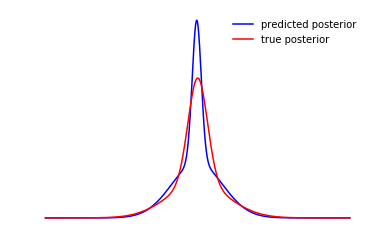

In [19]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))
    
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## Automatic posterior transformation

Automatic posterior transformation (APT, sometimes referred to as SNPE-C) improves on SNPE-A and SNPE-B by adjusting for the difference between the proposal and prior during learing. This means that APT doesn't rely on post-hoc corrections or importance weights, which leads to more accurate inference than the previous two methods.

This technique is described in "Automatic Posterior Transformation for Likelihood-Free Inference," by Greenberg, Nonnenmacher and Macke, ICML 2019.

In [20]:
from delfi.inference import APT

inf_APT = APT(generator=g, n_components=2, n_hiddens=[10], obs=x0)
logs, tds, posteriors = inf_APT.run(n_train=[2000, 1000], n_rounds=2)
posterior = posteriors[-1]

component 1: mixture weight = 0.49; mean = -0.01; variance = 0.09
component 2: mixture weight = 0.51; mean = -0.18; variance = 1.00


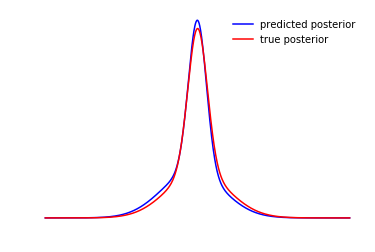

In [21]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))
    
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');c

## Atomic APT
We can also run APT with an atomic loss, where each point of training data consists of a multiple choice question. This allows us to use Masked Auto-regressive flows instead of Gaussian Mixtures as our conditional density estimators

In [127]:
inf_APT_atomic = APT(generator=g, n_hiddens=[10, 10], obs=x0, density='maf', n_mades=1)
logs, tds, posteriors = inf_APT_atomic.run(n_train=[2000, 1000], n_rounds=2, proposal='atomic_comb', train_on_all=True)
posterior = posteriors[-1]

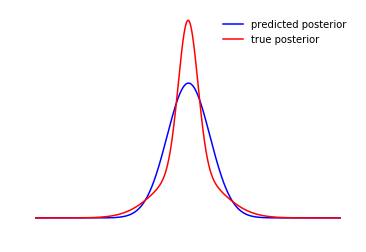

In [130]:
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
p_maf = posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False)
p_maf /= p_maf.mean()  # normalize, since atomic loss gives the posterior up to an unknown scale factor                       
plt.plot(p_maf, '-b')
p_true = true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False)
p_true /= p_true.mean()
plt.plot(p_true, '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## Adapting to other problems

In order to use `delfi` with a specific problem, you'd need to implement a simulator class and possibly summary statistics.

Simulators should inherit from a simulator base class. The base class for simulators specifies that each child needs to inherit a method called `gen_single()` -- the function that forward simulates a single $\theta$ to data. It should return a dictionary that contains the result under a key called `data`. [This is also detailled in the docstring of the base class](https://github.com/mackelab/delfi/blob/master/delfi/simulator/BaseSimulator.py). For an actual implementation, you can see the code for the mixture model we used above: https://github.com/mackelab/delfi/blob/master/delfi/simulator/GaussMixture.py.

For this example, we used the identity as a summary statistics. If you were to use summary statistics, consider the implementation of mean summary statistics for a basic example: https://github.com/mackelab/delfi/blob/master/delfi/summarystats/Mean.py, and again, there is a [base class specifying the interface](https://github.com/mackelab/delfi/blob/master/delfi/summarystats/BaseSummaryStats.py).